In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
import seaborn as sns

pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)


%matplotlib inline


In [2]:
data=pd.read_csv('LoanStats3a.csv',skip_blank_lines = True,skiprows = 1,skipfooter = 2,engine = 'python')

In [3]:
#data.head()

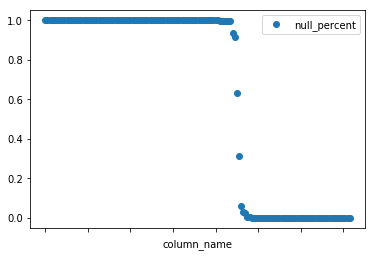

In [4]:
# check null percentage for all columns
null_df=data.isnull().mean().reset_index()
null_df.columns=['column_name','null_percent']
null_df.sort_values(by='null_percent',ascending=False, inplace=True)

null_df.plot(x='column_name',y='null_percent', style='o')

# Data Cleaning and Feature Engineerig

In [5]:
# drop columns with NA percentage>0.99
null_cols=null_df[null_df['null_percent']>0.99].column_name.tolist()
null_cols
df0=data.drop(null_cols,axis=1)
print("Dropping null columns...")

Dropping null columns...


In [6]:
#Drop rows with NA in target variable
df0.dropna(subset=['loan_status'],inplace=True)

In [7]:
#check loan_status counts for each category
df0['loan_status'].value_counts()

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64

In [8]:
df0.loan_status.unique()

array(['Fully Paid', 'Charged Off',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [9]:
# Derive response variable "default"
df0['default'] = df0.loan_status.apply(lambda x: 1 if x == "Charged Off" or x == "Does not meet the credit policy. Status:Charged Off" else 0)

In [10]:
df0.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,default
count,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42535.000000,42506.000000,42506.000000,15609.000000,3651.000000,42506.000000,42506.000000,4.253500e+04,42506.000000,42535.0,42535.0,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42390.0,42535.0,42506.000000,42390.0,42506.000000,41170.000000,42430.000000,42535.000000
mean,11089.722581,10821.585753,10139.938785,322.623063,6.913656e+04,13.373043,0.152449,1.081424,35.017618,59.175568,9.343951,0.058156,1.429786e+04,22.124406,0.0,0.0,12020.510262,11313.047967,9675.675936,2239.981444,1.516890,103.336085,14.445554,2612.955708,0.0,1.0,0.000094,0.0,0.143039,0.045227,0.000024,0.151193
std,7410.938391,7146.914675,7131.598014,208.927216,6.409635e+04,6.726315,0.512406,1.527455,22.418427,47.145396,4.496274,0.245713,2.201844e+04,11.592811,0.0,0.0,9094.926919,9038.663551,7105.750304,2585.057393,7.830064,737.939994,162.527690,4385.018207,0.0,0.0,0.009700,0.0,29.359579,0.208737,0.004855,0.358241
min,500.000000,500.000000,0.000000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,5200.000000,5000.000000,4950.000000,165.520000,4.000000e+04,8.200000,0.000000,0.000000,17.000000,0.000000,6.000000,0.000000,3.635000e+03,13.000000,0.0,0.0,5465.685189,4793.115000,4400.000000,657.100000,0.000000,0.000000,0.000000,211.005000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,9700.000000,9600.000000,8500.000000,277.690000,5.900000e+04,13.470000,0.000000,1.000000,33.000000,85.000000,9.000000,0.000000,8.821000e+03,20.000000,0.0,0.0,9682.251696,8956.080000,8000.000000,1339.160000,0.000000,0.000000,0.000000,528.320000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,15000.000000,15000.000000,14000.000000,428.180000,8.250000e+04,18.680000,0.000000,2.000000,51.000000,101.000000,12.000000,0.000000,1.725100e+04,29.000000,0.0,0.0,16428.176695,15544.335000,13499.995000,2803.090000,0.000000,0.000000,0.000000,3168.995000,0.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,13.000000,33.000000,120.000000,129.000000,47.000000,5.000000,1.207359e+06,90.000000,0.0,0.0,58886.473429,58563.680000,35000.020000,23886.470000,209.000000,29623.350000,7002.190000,36115.200000,0.0,1.0,1.000000,0.0,6053.000000,2.000000,1.000000,1.000000


In [11]:
# transform data types
# create a new feature 'credit_len'
# drop columns ['issue_d','earliest_cr_line']
df0['credit_len'] = (pd.to_datetime(df0['issue_d']) - pd.to_datetime(df0['earliest_cr_line'])).dt.days
df0.drop(['issue_d','earliest_cr_line'],axis = 1, inplace = True)

In [12]:
# fill NA in credit_len with 0
df0['credit_len'].fillna(0, inplace=True)
df0['credit_len'].head()

0    9830.0
1    4627.0
2    3682.0
3    5782.0
4    5813.0
Name: credit_len, dtype: float64

In [13]:
# drop columns that happen after default
drop_attr=['title','out_prncp','out_prncp_inv',
           'policy_code', 'delinq_amnt', 
           'recoveries','total_rec_late_fee',
           'last_pymnt_amnt','application_type','desc',
            'emp_title','loan_status',
             'zip_code','addr_state','total_rec_prncp',
            'total_rec_int','total_pymnt',
            'pymnt_plan','initial_list_status', 'last_pymnt_d',
            'last_credit_pull_d','hardship_flag','tax_liens',
            'total_pymnt_inv','collection_recovery_fee','debt_settlement_flag','next_pymnt_d','pymnt_plan']
            

In [14]:
#drop variables that are not available at the time of application
df0.drop(drop_attr,inplace=True, axis=1)
df0.shape

(42535, 29)

In [15]:
#check the only one factor columns
columns=df0.columns[df0.nunique(dropna = False)==1]
columns

Index([], dtype='object')

In [16]:
#drop one factor columns
df0.drop(columns=df0.columns[df0.nunique(dropna = False)==1], inplace=True)
df0.shape

(42535, 29)

In [17]:
#transform 'int_rate' and 'revol_util' to numerical variable
df0['int_rate'] = df0.int_rate.str.extract('(\d+)').astype('float')
df0['revol_util'] = df0.revol_util.str.extract('(\d+)').astype('float')

In [18]:
#transform emp_length and grade to numerical variable
mapping_dict = {
"emp_length": {
"10+ years": 10,
"9 years": 9,
"8 years": 8,
"7 years": 7,
"6 years": 6,
"5 years": 5,
"4 years": 4,
"3 years": 3,
"2 years": 2,
"1 year": 1,
"< 1 year": 0,
"n/a": 0
},
"grade":{
"A": 1,
"B": 2,
"C": 3,
"D": 4,
"E": 5,
"F": 6,
"G": 7
}
}
df0 = df0.replace(mapping_dict)
df0[['emp_length','grade']].head()

,emp_length,grade
0,10.0,2
1,0.0,3
2,10.0,3
3,10.0,3
4,1.0,2


In [19]:
#categorical variables
attr_cat=['term', 'home_ownership','verification_status','purpose']
attr_o = [col for col in df0.select_dtypes(include = 'object').columns.tolist() if col not in ['grade','sub_grade']]

In [20]:
# dummy categorical variables
df1 = pd.get_dummies(df0,prefix_sep = '_', columns = attr_o, dummy_na = True, sparse = False)

In [21]:
df1['pub_rec_bankruptcies'].isna().sum()

1365

In [22]:
attr_mis=['mths_since_last_delinq','revol_util','collections_12_mths_ex_med',
          'chargeoff_within_12_mths','pub_rec_bankruptcies']

In [23]:
df2=df1[np.isfinite(df1['delinq_2yrs'])]
df3=df2[np.isfinite(df2['credit_len'])]
df3.isnull().sum()[df3.isnull().sum()>0]

emp_length                     1112
mths_since_last_delinq        26897
mths_since_last_record        38855
revol_util                       61
collections_12_mths_ex_med      116
chargeoff_within_12_mths        116
pub_rec_bankruptcies           1336
dtype: int64

In [24]:
# create new columns with columnname_nan
df4=df3[attr_mis].isnull().astype(int).add_suffix('_nan')
df5=pd.concat([df3,df4],axis=1)
df5.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,pub_rec_bankruptcies,default,credit_len,term_ 36 months,term_ 60 months,term_nan,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,verification_status_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,mths_since_last_delinq_nan,revol_util_nan,collections_12_mths_ex_med_nan,chargeoff_within_12_mths_nan,pub_rec_bankruptcies_nan
0,5000.0,5000.0,4975.0,10.0,162.87,2,B2,10.0,24000.0,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.0,9.0,0.0,0.0,0.0,0.0,0,9830.0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2500.0,2500.0,2500.0,15.0,59.83,3,C4,0.0,30000.0,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.0,4.0,0.0,0.0,0.0,0.0,1,4627.0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2400.0,2400.0,2400.0,15.0,84.33,3,C5,10.0,12252.0,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.0,10.0,0.0,0.0,0.0,0.0,0,3682.0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,10000.0,10000.0,10000.0,13.0,339.31,3,C1,10.0,49200.0,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,0.0,0.0,0.0,0.0,0,5782.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,3000.0,3000.0,3000.0,12.0,67.79,2,B5,1.0,80000.0,17.94,0.0,0.0,38.0,NaN,15.0,0.0,27783.0,53.0,38.0,0.0,0.0,0.0,0.0,0,5813.0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [25]:
#fill na with 0
#df5.fillna(df5.median(skipna=True),inplace=True)
df5.fillna(0, inplace=True)

# Build Logistic Model

In [26]:
#features
attr = [col for col in df5.columns if col not in ['default','sub_grade','total_pymnt','total_pymnt_inv']]

In [27]:
# train, test datasets
train_x,test_x,train_y,test_y=train_test_split(df5[attr],df5['default'],test_size=0.3,random_state=123)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

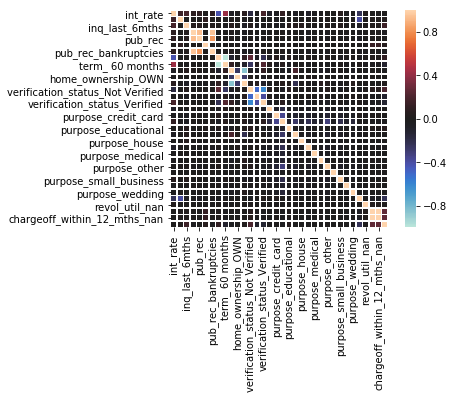

In [28]:
#Logistic Regression Model
test=pd.concat([train_x,train_y],axis=1)
test[test.columns].corr()['default']

selector=RFECV(estimator=LogisticRegression(),step=1,cv=5,scoring='roc_auc')
selector.fit(train_x,train_y)

#selector.support_
#selector.ranking_
#selector.n_features_
features=train_x.columns[selector.support_]
train_x_1=train_x[features]
test_x_1=test_x[features]

cor=train_x_1.corr()
mask=np.zeros_like(cor,dtype=np.bool)
sns.heatmap(cor,mask=mask,center=0,square=True,linewidths=0.5)
plt.show()


In [29]:
#Use lasso to select features
param_grid = [
    {
     'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']},
]
clf = GridSearchCV(estimator=LogisticRegression(), param_grid = param_grid, scoring='roc_auc',cv = 5, verbose=True, n_jobs=-1)
clf.fit(train_x_1,train_y)
print(clf.best_params_)

lr=LogisticRegression(C=1.62,penalty='l1', solver='liblinear')
lr.fit(train_x_1,train_y)

feature_df=pd.DataFrame({'feature':train_x_1.columns.get_values(),'coef':lr.coef_[0]})
feature_l=train_x_1.columns[lr.coef_[0]!=0]
pred_lr_train=lr.predict_proba(train_x_1)[:,1]
roc_auc_score(train_y,pred_lr_train)

pred_lr_test=lr.predict_proba(test_x_1)[:,1]
roc_auc_score(test_y,pred_lr_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.2s finished


{'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'liblinear'}


0.6938653982789356

In [30]:
#train auc score
roc_auc_score(train_y,pred_lr_train)

0.6897209153263976

In [31]:
#test auc score
roc_auc_score(test_y,pred_lr_test)

0.6938653982789356

# Data exploration

In [32]:
df=data.copy()

In [33]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [34]:
df['year']=df['issue_d'].dt.year.astype(int,errors='ignore')
df['default'] = df.loan_status.apply(lambda x: 1 if x == "Charged Off" or x == "Does not meet the credit policy. Status:Charged Off" else 0)

Text(0, 0.5, 'Total loan amount issued')

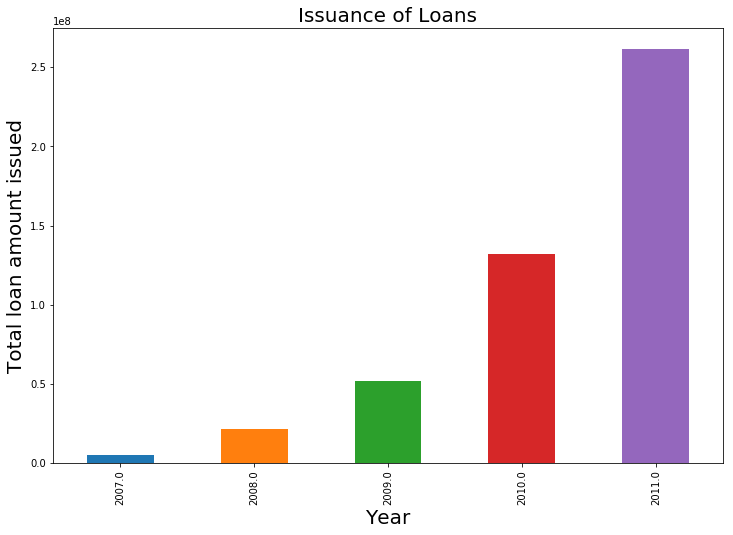

In [35]:
# The year of 2011 was the year with the highest amount of loans were issued 
# Loans increase gradually from 2007 to 2011
plt.figure(figsize=(12,8))
#sns.barplot('year', 'loan_amnt', data=df, palette='tab10')
df.groupby('year')['loan_amnt'].sum().plot(kind='bar')
plt.title('Issuance of Loans', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Total loan amount issued', fontsize=20)

[Text(0, 0.5, '(%)')]

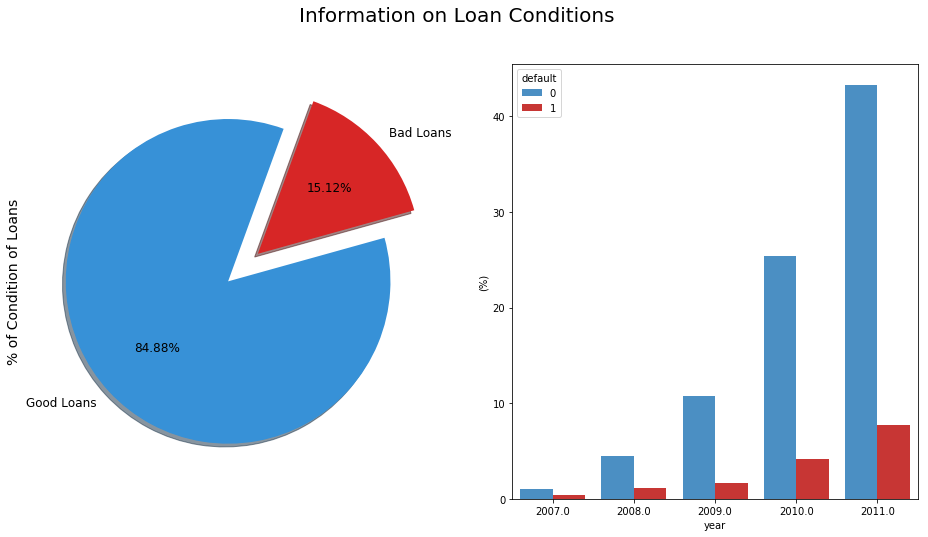

In [36]:
# Good and bad loan percentage
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df0["default"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)

ax[0].set_ylabel('% of Condition of Loans', fontsize=14)
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amnt", hue="default", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")


In [37]:
df0['int_rate'].describe()

count    42535.000000
mean        11.592759
std          3.743598
min          5.000000
25%          9.000000
50%         11.000000
75%         14.000000
max         24.000000
Name: int_rate, dtype: float64

In [38]:
# Average interest is 11.59% Anything above this will be considered of high risk let's see if this is true.
df0['interest_level'] = np.nan
lst = [df0]

for col in lst:
    col.loc[col['int_rate'] <= 13.23, 'interest_level'] = 'Low'
    col.loc[col['int_rate'] > 13.23, 'interest_level'] = 'High'

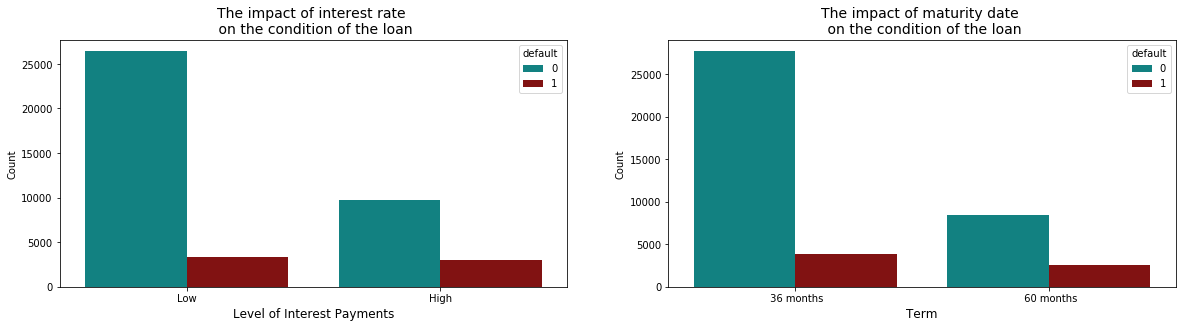

In [39]:
# Factos that might affect loan default risk

from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_level', data=df0, 
                  palette=palette, hue='default')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
#ax1 = sns.countplot(x='interest_level', data=df0, 
                   #palette=palette, hue='term')
ax1 = sns.countplot(x='term', data=df0, 
                   palette=palette, hue='default')
ax1.set_title('The impact of maturity date \n on the condition of the loan', fontsize=14)
ax1.set_xlabel('Term', fontsize=12)
ax1.set_ylabel('Count')


plt.show()

In [40]:
df.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

In [41]:
# Total return rate
total_funded_amount=df['funded_amnt_inv'].sum()
total_payment_amount=df['total_pymnt_inv'].sum()

total_return_rate=(total_payment_amount-total_funded_amount)/total_funded_amount
total_return_rate

0.1156919392949804

In [42]:
d1=df.groupby('year')['funded_amnt_inv','total_pymnt_inv'].sum().reset_index().sort_values(by='year')
d1['return_rate']= (d1['total_pymnt_inv']-d1['funded_amnt_inv'])/d1['funded_amnt_inv']
d1

,year,funded_amnt_inv,total_pymnt_inv,return_rate
0,2007.0,7.993848e+05,8.066248e+05,0.009057
1,2008.0,7.614383e+06,7.975755e+06,0.047459
2,2009.0,4.577788e+07,4.954710e+07,0.082337
3,2010.0,1.230846e+08,1.373104e+08,0.115578
4,2011.0,2.540260e+08,2.855606e+08,0.124139


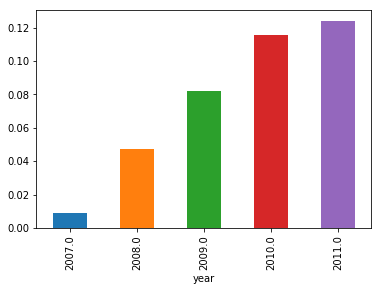

In [43]:
# yearly loan return rate
plt.clf()
d1.groupby('year')['return_rate'].sum().plot(kind='bar')
plt.show()